# HW2.py
### Grant Cloud
### CS 4641 - Machine Learning
### 10/6/19

<p>Imports</p>

In [1]:
import numpy as np
import time
import matplotlib, os.path
import matplotlib.pyplot as plt

<p>Provided functions (with my modifications)</p>

In [2]:
## Data loading utility functions
def get_test_train(fname,seed,datatype):
    '''
    Returns a test/train split of the data in fname shuffled with
    the given seed


    Args:
        fname: A str/file object that points to the CSV file to load, passed to
                    numpy.genfromtxt()
        seed:        The seed passed to numpy.random.seed(). Typically an int or long
        datatype:    The datatype to pass to genfromtxt(), usually int, float, or str


    Returns:
        train_X:    A NxD numpy array of training data (row-vectors), 80% of all data
        train_Y:    A Nx1 numpy array of class labels for the training data
        test_X:     A MxD numpy array of testing data, same format as train_X, 20% of all data
        test_Y:     A Mx1 numpy array of class labels for the testing data
    '''
    data = np.genfromtxt(fname,delimiter=',',dtype=datatype)
    np.random.seed(seed)
    shuffled_idx = np.random.permutation(data.shape[0])
    cutoff = int(data.shape[0]*0.8)
    train_data = data[shuffled_idx[:cutoff]]
    test_data = data[shuffled_idx[cutoff:]]
    train_X = train_data[:,:-1].astype(float)
    train_Y = train_data[:,-1].reshape(-1,1)
    test_X = test_data[:,:-1].astype(float)
    test_Y = test_data[:,-1].reshape(-1,1)
    return train_X, train_Y, test_X, test_Y

def load_HTRU2(path='data'):
    return get_test_train(os.path.join(path,'HTRU_2.csv'),seed=1567708903,datatype=float)

def load_iris(path='data'):
    return get_test_train(os.path.join(path,'iris.data'),seed=1567708904,datatype=str)

## The "digits" dataset has a pre-split set of data, so we won't do our own test/train split
def load_digits(path='data'):
    train_data = np.genfromtxt(os.path.join(path,'optdigits.tra'),delimiter=',',dtype=float)
    test_data = np.genfromtxt(os.path.join(path,'optdigits.tes'),delimiter=',',dtype=float)
    return train_data[:,:-1], train_data[:,-1].reshape(-1,1), test_data[:,:-1], test_data[:,-1].reshape(-1,1)

## You can use this dataset to debug your implementation
def load_test(path='data'):
    return get_test_train(os.path.join(path,'data1.dat'),seed=1568572210, datatype=float)

class KNN():
    '''
    A very simple instance-based classifier.


    Finds the majority label of the k-nearest training points. Implements 3 distance functions:
     - euclid: standard euclidean distance (l2)
     - manhattan: taxi-cab, or l1 distance
     - mahalanobis: euclidean distance after centering and scaling by the inverse of
       the standard deviation of each component in the training data
    '''

    def __init__(self, train_X, train_Y):
        '''
        Stores the training data and computes some useful statistics for the mahalanobis
        distance method


        Args:
            train_X: NxD numpy array of training points. Should be row-vector form
            train_Y: Nx1 numpy array of class labels for training points.
        '''
        self.train_X = train_X
        self.train_Y = train_Y
        self.x_mean = self.train_X.mean(axis=0)
        self.x_std = self.train_X.std(axis=0)
        if 0 in self.x_std:
            self.iList = [i for i in range(train_X.shape[1]) if np.all(train_X[0,i] == train_X[:,i])]
            train_X = np.delete(train_X, self.iList, axis=1) # delete duplicate features from train data
            self.train_X = train_X
            self.x_mean = self.train_X.mean(axis=0)
            self.x_std = self.train_X.std(axis=0)
        self.train_X_centered_scaled = (train_X-np.tile(self.x_mean,(train_X.shape[0],1)))/self.x_std

    def euclid(self,x_q):
        '''
        Returns a numpy array containing the euclidean distance from the test point, x_q
        to each of the points in the training data.


        Args:
            x_q:    The query point, a row vector with the same shape as one row of the
                training data in self.train_X


        Returns:
            dists:  A Nx1 numpy array containing the distance to each of the training
                    data points
        '''
        # GC (10/8/19) finished
        dists = np.sqrt(np.sum((self.train_X - x_q) ** 2, axis=1)).reshape(-1,1)
        return dists
    def manhattan(self,x_q):
        '''
        Returns a numpy array containing the manhattan distance from the test point, x_q
        to each of the points in the training data.


        Args:
            x_q:    The query point, a row vector with the same shape as one row of the
                    training data in self.train_X


        Returns:
            dists:  A Nx1 numpy array containing the distance to each of the training
                    data points
        '''
        # GC (10/8/19) finished
        dists = np.sum(np.abs(self.train_X - x_q), axis=1).reshape(-1,1)
        return dists
    def mahalanobis(self,x_q):
        '''
        Returns a numpy array containing the centered and normalized distance from the test
        point, x_q to each of the points in the training data.


        Args:
            x_q:    The query point, a row vector with the same shape as one row of the
                    training data in self.train_X


        Returns:
            dists:  A Nx1 numpy array containing the distance to each of the training
                    data points
        '''
        # GC (10/9/19) finished
        x_q_tilde = (x_q - self.x_mean)/(self.x_std)
        dists = np.sqrt(np.sum((self.train_X_centered_scaled - x_q_tilde) ** 2, axis=1)).reshape(-1,1)
        return dists
    def query_single_pt(self,distances,k):
        '''
        Returns the most common class label of the k-neighbors with the lowest distance as
        computed by the distance function d


        Args:
            query_X:    The query point, a row vector with the same shape as one row of the
                        training data in self.train_X
            k:          The number of neighbors to check
            d:          The distance function to use


        Returns:
            label:      The label of the most common class
        '''
        ## Note: the argument d is a function pointer. You could pass in knn.euclid or
        ## knn.manhattan or knn.mahalanobis, or any other function you like, and here's
        ## how you might use it
        # GC (10/9/19) finished
        labels = self.train_Y[np.argpartition(distances, k)][:k].reshape(-1,) #returns labels of the k smallest distance indexes unsorted
        yLabel, counts = np.unique(labels, return_counts=True)
        label = yLabel[np.argmax(counts)]
        return label
    def query(self,data_X,k,d):
        '''
        A convenience method for calling query_single_pt on each point in a dataset,
        such as those returned by get_test_train() or the various load_*() functions.
        If you change the API for any of the other methods, you'll probably have to rewrite
        this one.
        '''
        return np.array([self.query_single_pt(self.distanceList[i],k) for i in range(data_X.shape[0])]).reshape(-1,1)
    def test_loss(self,max_k,d,test_X,test_Y):
        '''
        A convenience method for computing the misclasification rate for a range of k
        values.


        Args:
            max_k:  The maximum size of the neighborhood to test. Note, if you let this
                    be too large, it may take a very long time to finish. You may want
                    to add some code to print out after each iteration to see how long
                    things are taking
            d:      The distance function to use
            test_X: The data to compute the misclassification rate for
            test_Y: The correct labels for the test data


        Returns:
            loss:   A numpy array with max_k entries containing the misclassification
                    rate on the given data for each value of k. Useful for passing to
                    matplotlib plotting methods.
        '''
        self.distanceList = []
        if test_X.shape[1] != self.train_X.shape[1]: # used in Optidigts to remove identical features when testing test loss
            test_X = np.delete(test_X, self.iList, axis=1)
        for query_X in test_X:
            distances = d(query_X).reshape(-1,)
            self.distanceList.append(distances)
        loss = np.zeros(max_k)
        for k in range(1,max_k+1):
            loss[k-1] = (test_Y != self.query(test_X,k,d)).sum()/float(test_X.shape[0])
        return loss
    def train_loss(self, max_k, d):
        '''
        A convenience method which calls self.test_loss() on the training data. Same
        arguments as for test_loss.
        '''
        return self.test_loss(max_k,d,self.train_X,self.train_Y)

## You should use this function for computing the sigmoid, as it prevents numerical
## overflow and underflow
def sigmoid(z):
    return np.clip(1.0/(1.0+np.exp(-z)),np.finfo(float).eps,1.0-np.finfo(float).eps)

class LogisticRegression():
    '''
    A simple linear classifier for binary datasets


    Finds the best linear decision boundary, and models the probability of the postive class
    label. Implements gradient descent with momentum to fit the model. Note that most
    of the methods provided to you in this class assume that data passed in (train_X, query_X,
    etc.) do not already include a constant offset term. You may change this if you like, but
    you will probably have to change some of the provided code to match.
    '''
    def __init__(self, train_X, train_Y, positive_class_label):
        '''
        Stores the training data, the class label for positive samples, and initializes
        self.Theta to None.


        Args:
            train_X:
                A NxD numpy array of training data points (row-vector format)

            train_Y:
                A Nx1 numpy array of class labels for each of the training points

            positive_class_label:
                The label of the "positive" class. Should be one of the labels in train_Y.
        '''
        self.train_X = train_X
        self.train_Y = train_Y
        self.positive_class_label = positive_class_label
        self.Theta = None
    def prob_single_pt(self,query_X):
        '''
        Returns the probability that query_X belongs to the positive class


        Args:
            query_X:    A numpy array with shape (D,)


        Returns:
            prob:       The probability that query_X belongs to the positive class
        '''
        query_X = np.insert(query_X, 0, 1) # add bias column to the query point
        prob = sigmoid(self.Theta.T.dot(query_X))
        return prob

    def prob(self,data_X):
        '''
        A convenience method for calling prob_single_pt for an array of test points


        Args:
            data_X:      A numpy array with shape (N,D)


        Returns:
            prob:       A numpy array with shape (N,1) with the probability of the class label
                        for the corresponding point.
        '''
        return np.array([self.prob_single_pt(x_pt) for x_pt in data_X]).reshape(-1,1)

    def negative_log_likelihood(self,target_Theta=None):
        '''
        Computes the negative log likelihood of the data under the model with the given parameters


        Args:
            target_Theta:    the parameters to use, defaulting to self.Theta


        Returns:
            NLL:             The negative log likelihood.
        '''
        if target_Theta is None:
            target_Theta = self.Theta
        # Here's an example of turning train_Y into a vector of 0's and 1's
        # so that 1's match up with labels == positive_class_label and 0's
        # otherwise. You may find this useful in NLL_gradient
        Y = (self.train_Y == self.positive_class_label).astype(float)
        X = np.hstack([np.ones(self.train_X.shape[0]).reshape(-1,1),self.train_X])
        H = sigmoid(X.dot(target_Theta))
        NLL = -1.0*((Y*np.log(H)) + ((1.0-Y)*np.log(1.0-H))).sum()
        return NLL

    def NLL_gradient(self):
        '''
        Computes the gradient of the negative log likelihood with respect to the parameters
        self.Theta.


        Returns:
            grad:   A (D+1)x1 numpy array, column vector, representing the gradient
        '''
        # TODO: YOUR CODE HERE
        X = np.hstack([np.ones(self.train_X.shape[0]).reshape(-1,1),self.train_X])
        H = sigmoid(X.dot(self.Theta))
        Y = (self.train_Y == self.positive_class_label).astype(float)
        grad = X.T.dot(H - Y)
        return grad

    def gradient_descent(self, initial_Theta, alpha=1.2e-3, num_iters=200000, print_every=500000, regularization=0.01, epsilon=1e-4):
        '''
        Performs gradient descent to optimize self.Theta to fit the training data


        Args:
            initial_Theta:  A numpy (D+1)x1 array to start the optimization from
            alpha:          The learning rate, a number
            num_iters:      The maximum number of iterations to perform, may stop before
            print_every:    Print out the current iteration, NLL, and Theta every so often
            regularization: The factor to penalize ||Theta|| by. Necessary to prevent overfitting
                            to linearly separable data
            epsilon:        Stop if ||Theta - prev_Theta|| < epsilon
        '''
        self.Theta = initial_Theta
        prev_Theta = self.Theta
        for k in range(1,num_iters+1):
            cur_NLL = self.negative_log_likelihood()
            if print_every and (k % print_every)==0:
                print("Iteration: {}, NLL: {}, Theta: {}".format(k,cur_NLL,self.Theta))
            # We're not including regularization in the gradient, and we shouldn't
            # regularize the constant offset term, so we add it here
            reg_term = self.Theta.copy()
            reg_term[0] = 0.0
            reg_term = regularization*reg_term
            grad = (self.NLL_gradient()+reg_term)
            # Note that we're scaling the gradient by the size of the training points. If you
            # already did this in the gradient function, you'll need to modify this line
            new_Theta = self.Theta - alpha*(grad/self.train_X.shape[0])
            prev_Theta = self.Theta
            self.Theta = new_Theta
            if np.linalg.norm(new_Theta-prev_Theta)<epsilon:
                print("Converged, iteration {}".format(k))
                break

def multiclass_logistic_score(list_of_logreg, test_X, test_Y):
    '''
    A utility function for computing the One-vs-Rest score of a list of logistic regression
    classifiers. O-v-R score compares the label of the highest-probability model with the
    true label. Higher is better. Score and misclassification loss are related
    loss() = 1-score()

    make sure when you are comparing performance between KNN and LogisticRegression, you're
    comparing loss to loss, or score to score!


    Args:
        list_of_logreg: A list of LogisticRegression objects, correctly initialized and fit
        test_X:         The data to test on
        test_Y:         The class labels for the testing data


    Returns:
        score:  The fraction of correctly identified labels.
    '''
    classes = [lr.positive_class_label for lr in list_of_logreg]
    probs = np.hstack([lr.prob(test_X) for lr in list_of_logreg])
    max_prob = np.argmax(probs,axis=1)
    Y_hat = np.array([classes[mp] for mp in max_prob]).reshape(-1,1)
    score = (Y_hat == test_Y).sum()/test_Y.shape[0]
    return score

<p>A function that will create our loss plots for the kNN functions</p>

In [3]:
def showErrorByK(loss, loss_tr, method, data):
    plt.clf()
    k = [i for i in range(1,len(loss)+1)]
    plt.plot(k, loss_tr, '-b', label='Train Loss')
    plt.plot(k, loss, '-r', label='Test Loss')
    plt.legend(loc='upper left')
    plt.title('Comparison of Loss vs. # of kNN', fontsize=20)
    plt.ylabel('Error (Loss)', fontsize=16)
    plt.xlabel('# of kNN (k)', fontsize=16)
    print('\n{}'.format(method))
    print('{}'.format(data))
    plt.show()

### 1a)

<p>Eucliden Distance on the <b>Iris dataset:</b></p>

Min Train Loss Euclid: 0.0,(k=1)
Min Test Loss Euclid: 0.0,(k=15)

Euclidean
Iris


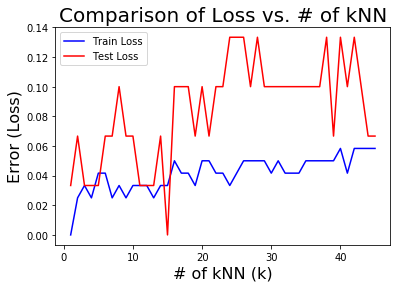

In [4]:
test_data = load_iris()
test_KNN = KNN(test_data[0],test_data[1])
kNN_euc_loss_tr = test_KNN.train_loss(45,test_KNN.euclid)
kNN_euc_loss = test_KNN.test_loss(45,test_KNN.euclid,test_data[2],test_data[3])
print('Min Train Loss Euclid: {},(k={})'.format(min(kNN_euc_loss_tr),np.argmin(kNN_euc_loss_tr)+1))
print('Min Test Loss Euclid: {},(k={})'.format(min(kNN_euc_loss),np.argmin(kNN_euc_loss)+1))
showErrorByK(kNN_euc_loss,kNN_euc_loss_tr,'Euclidean','Iris')

<p>A good <i>k</i> for the Iris dataset using Euclidean distance would be 13, there are a few reasons for this. Firstly, we want an odd number for <i>k</i> to avoid ties between classes. Secondly, we want to choose a <i>k</i> with a low test loss. <i>k</i> = 13 is the second lowest loss at just under .04 , meaning our model correctly classifies a query point over 96% of the time. We also observe that the train loss at <i>k</i> = 13 is slightly lower than the test loss. This shows that there is very little ( if any ) overfitting in the model at <i>k</i> = 13 to the training data. This implies that our model will generalize well at <i>k</i> = 13 ( and it did, with a test loss almost matching the train loss ).<p> </p>It's also worth explaining why I did not choose <i>k</i> = 15. Despite being odd, larger than 13, and having a loss of 0 ( so tempting ), the loss at <i>k</i> = 15 seems to be an outlier. Logically, the model shouldn't predict better on testing data than training data and the loss at <i>k</i> = 15 is in the bottom of a very skinny valley. Knowing the iris dataset is relatively small, I suspect that more training data would "smoothen" out the plots (similar to what you will see in the larger digits and HTRU2 datasets) and be less variant. Because this is a small dataset that is variant, I choose <i>k</i> = 13 as a safer ( or more reliable ) choice.</p>
<p></p>
<p>Euclidean distance on the <b>Optidigits dataset:</b></p>

Min Train Loss Euclid: 0.0,(k=1)
Min Test Loss Euclid: 0.02003338898163606,(k=1)

Euclidean
Digits


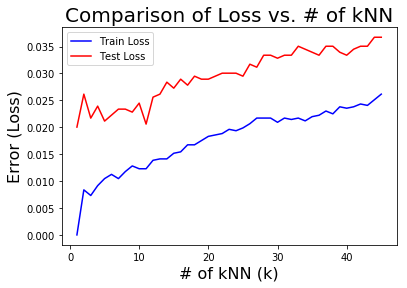

In [5]:
test_data = load_digits()
test_KNN = KNN(test_data[0],test_data[1])
kNN_euc_loss_tr = test_KNN.train_loss(45,test_KNN.euclid)
kNN_euc_loss = test_KNN.test_loss(45,test_KNN.euclid,test_data[2],test_data[3])
print('Min Train Loss Euclid: {},(k={})'.format(min(kNN_euc_loss_tr),np.argmin(kNN_euc_loss_tr)+1))
print('Min Test Loss Euclid: {},(k={})'.format(min(kNN_euc_loss),np.argmin(kNN_euc_loss)+1))
showErrorByK(kNN_euc_loss,kNN_euc_loss_tr,'Euclidean','Digits')

<p>For the Optidigits dataset using Euclidian distance, I choose <i>k</i> = 11 . Same as the Iris dataset, we choose the largest odd number (to reduce complexity and make sure there are no ties ) with a low loss. At <i>k</i> = 11 , we have the minimum loss, which is 0.02 . Furthermore, at <i>k</i> = 11 we see the smallest gap between the train loss and test loss. This implies that at <i>k</i> = 11 we have the least amount of overfitting by the model to the training data, and thus will generalize better to future test data sets than other <i>k</i> values.</p><p>Comparing the performance of our models in the Iris dataset vs. the Optidigits dataset, we can see the Optidigits dataset is much less variant than the Iris dataset and the model consistently performs much better ( lower loss ) in the Optidigits dataset. This is because there is much more training data in the Optidigits dataset. I'll discuss it more in the logarithmic regression section, but it's important to note the improvement we saw in the kNN model when more training data was introduced.</p>
<p></p>
<p>Euclidean distance on the <b>HTRU2 dataset:</b></p>

Min Train Loss Euclid: 0.0,(k=1)
Min Test Loss Euclid: 0.020391061452513966,(k=12)

Euclidean
HTRU2


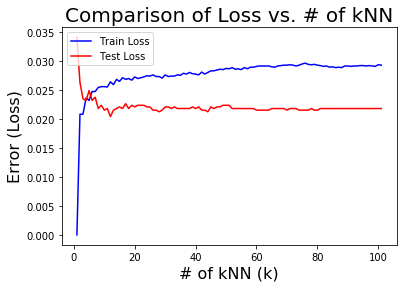

In [6]:
test_data = load_HTRU2()
test_KNN = KNN(test_data[0],test_data[1])
kNN_euc_loss_tr = test_KNN.train_loss(101,test_KNN.euclid)
kNN_euc_loss = test_KNN.test_loss(101,test_KNN.euclid,test_data[2],test_data[3])
print('Min Train Loss Euclid: {},(k={})'.format(min(kNN_euc_loss_tr),np.argmin(kNN_euc_loss_tr)+1))
print('Min Test Loss Euclid: {},(k={})'.format(min(kNN_euc_loss),np.argmin(kNN_euc_loss)+1))
showErrorByK(kNN_euc_loss,kNN_euc_loss_tr,'Euclidean','HTRU2')

<p>For the HTRU2 dataset with Euclidean distance, I choose <i>k</i> = 11 . Similar to the Optidigits dataset, we choose a large odd k ( to reduce complexity ) while minizing test loss. At larger and smaller values of <i>k</i> we see increased loss. We also note that the test loss flattens our as k approaches 100 and performs extremely consistently along a range of <i>k</i> values.</p><p>One important trend to notice is the smaller training loss than test loss. Logically this shouldn't occur ( as stated in the Optidigits Euclidean model ) , but the trend is consistent across a range of <i>k</i>s. One possible explanation for this is that the testing data has fewer "edge" points than the training data. Visually speaking, kNN does a very good job of classifying test points surrounded by lots of training points, and since the HTRU2 dataset has so many training points, the model has "easier" predictions ( predictions where the point is surrounded by a large majority class ). We can see the reverse impact of this on the Iris dataset, where there are fewer training data points and thus  more "edge" query points, where the classification is not a large majority but rather a split vote between multiple classes. This leads to increased loss by kNN in the smaller training datasets as compared to the larger datasets. So in the case of HTRU2, a potential explanation for the lower test loss is that the testing points are "easy" predictions of points surrounded by a large majority of similar class points, whereas in the training dataset the model is forced to make predictions on "edge" points surrounded by multiple classes where there is a split vote going to the majority ( and thus is more likely to misclassify ).</p>

### 1b)

<p>Manhattan distance on the <b>Iris dataset:</b></p>

Min Train Loss Man: 0.03333333333333333,(k=1)
Min Test Loss Man: 0.03333333333333333,(k=1)

Manhattan
Iris


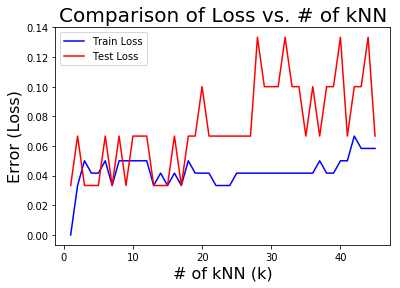

In [7]:
test_data = load_iris()
test_KNN = KNN(test_data[0],test_data[1])
kNN_man_loss_tr = test_KNN.train_loss(45,test_KNN.manhattan)
kNN_man_loss = test_KNN.test_loss(45,test_KNN.manhattan,test_data[2],test_data[3])
print('Min Train Loss Man: {},(k={})'.format(min(kNN_man_loss),np.argmin(kNN_man_loss)+1))
print('Min Test Loss Man: {},(k={})'.format(min(kNN_man_loss),np.argmin(kNN_man_loss)+1))
showErrorByK(kNN_man_loss,kNN_man_loss_tr,'Manhattan','Iris')

<p>A good fit for the Iris dataset with Manhattan distance is <i>k</i> = 15 . For the same reasons we chose <i>k</i> = 13 in the Iris dataset with Euclidean distance, <i>k</i> = 15  with Manhattan distance provides the maximumm odd <i>k</i> with a minimized loss. Again, because of the small size of the dataset, we see high variances and relatively bad loss values for the Iris dataset with Manhattan distance (in comparison to the other datasets with larger training datasets ). Compared to the Euclidean distance model on the Iris dataset, the Manhattan model performed about that same.</p>
<p></p>
<p>Manhattan distance on the <b>Optidigits dataset:</b></p>

Min Train Loss Man: 0.025598219254312743,(k=1)
Min Test Loss Man: 0.025598219254312743,(k=1)

Manhattan
Digits


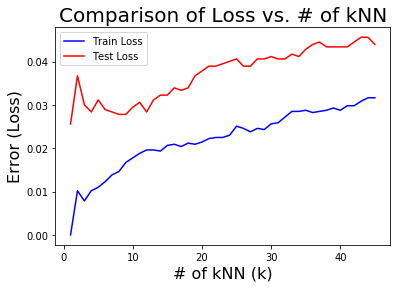

In [8]:
test_data = load_digits()
test_KNN = KNN(test_data[0],test_data[1])
kNN_man_loss_tr = test_KNN.train_loss(45,test_KNN.manhattan)
kNN_man_loss = test_KNN.test_loss(45,test_KNN.manhattan,test_data[2],test_data[3])
print('Min Train Loss Man: {},(k={})'.format(min(kNN_man_loss),np.argmin(kNN_man_loss)+1))
print('Min Test Loss Man: {},(k={})'.format(min(kNN_man_loss),np.argmin(kNN_man_loss)+1))
showErrorByK(kNN_man_loss,kNN_man_loss_tr,'Manhattan','Digits')

<p>A good fit for the Optidigits dataset with Manhattan distance is <i>k</i> = 11, same as with Euclidean distance. We, once again, choose the largest odd <i>k</i> with a small loss. This point also has the smallest gap between the training loss and test loss, thus reducing overfitting on the training data and making for a more generalizable model.</p><p>We also note that the Manhattan distance model performed <em>worse</em> than the Euclidean distance model at <i>k</i> = 11 for the Optidigits dataset. This occurs because points that are closer on a diagonal straight line distance ( Euclidean distance ) are ranked as farther using Manhattan distance ( since distance is calculated as the sum of distance traveled on each axis as opposed to the smaller value of direct line between points ) . This discrepancy of points that are farther away using Euclidean distance but luckily end up directly on a axis used to calculate Manhattan distance causes increased misclassification in the model.</p>
<p></p>
<p>Manhattan distance on the <b>HTRU2 dataset:</b></p>

Min Train Loss Man: 0.01983240223463687,(k=45)
Min Test Loss Man: 0.01983240223463687,(k=45)

Manhattan
HTRU2


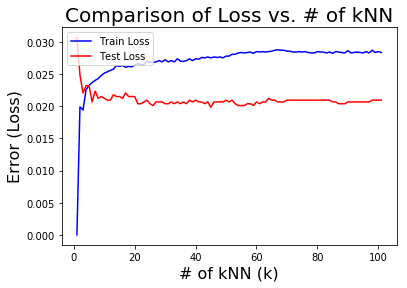

In [9]:
test_data = load_HTRU2()
test_KNN = KNN(test_data[0],test_data[1])
kNN_man_loss_tr = test_KNN.train_loss(101,test_KNN.manhattan)
kNN_man_loss = test_KNN.test_loss(101,test_KNN.manhattan,test_data[2],test_data[3])
print('Min Train Loss Man: {},(k={})'.format(min(kNN_man_loss),np.argmin(kNN_man_loss)+1))
print('Min Test Loss Man: {},(k={})'.format(min(kNN_man_loss),np.argmin(kNN_man_loss)+1))
showErrorByK(kNN_man_loss,kNN_man_loss_tr,'Manhattan','HTRU2')

<p>A good <i>k</i> for HTRU2 with Manhattan distance is <i>k</i> = 45, with a test loss of 0.0198. As previously stated, we choose the largest odd <i>k</i> while minimizing loss. For the same reasons stated in the HTRU2 with Euclidean model, we see a lower test loss than train loss. Overall, we see about the slightly less loss and variance in the HTRU2 Manhattan model than the HTRU2 Euclidean model.</p>
<p></p>
<p>Mahalanobis distance using the <b>Iris dataset:</b></p>

Min Train Loss Mah: 0.0,(k=1)
Min Test Loss Mah: 0.03333333333333333,(k=1)

Mahalanobis
Iris


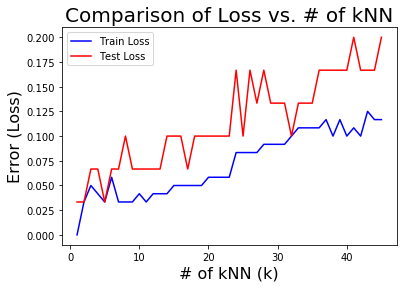

In [10]:
test_data = load_iris()
test_KNN = KNN(test_data[0],test_data[1])
kNN_mah_loss_tr = test_KNN.train_loss(45,test_KNN.mahalanobis)
kNN_mah_loss = test_KNN.test_loss(45,test_KNN.mahalanobis,test_data[2],test_data[3])
print('Min Train Loss Mah: {},(k={})'.format(min(kNN_mah_loss_tr),np.argmin(kNN_mah_loss_tr)+1))
print('Min Test Loss Mah: {},(k={})'.format(min(kNN_mah_loss),np.argmin(kNN_mah_loss)+1))
showErrorByK(kNN_mah_loss,kNN_mah_loss_tr,'Mahalanobis','Iris')

<p>For the Iris dataset with Mahalanobis distance we see the same general trends that the other Iris models had: high variance and ( relatively ) high loss. Unlike the other Iris models, the Mahalanobis model performs better at lower values of <i>k</i> ( more complex ). There is a clear increase in training loss as <i>k</i> increases, thus the best <i>k</i> for the Iris Mahalanobis model is <i>k</i> = 5 . At <i>k</i> = 5 we see an odd value of <i>k</i>, a minimal loss ( 0.0333 ) and a small ( if any ) difference between the train loss and test loss ( good generalizability ). The euclidean distance model performed the best of all three models on the iris dataset.</p>
<p></p>
<p>Mahalanobis distance using the <b>Optidigits dataset:</b></p>

Min Train Loss Mah: 0.0,(k=1)
Min Test Loss Mah: 0.035058430717863104,(k=3)

Mahalanobis
Digits


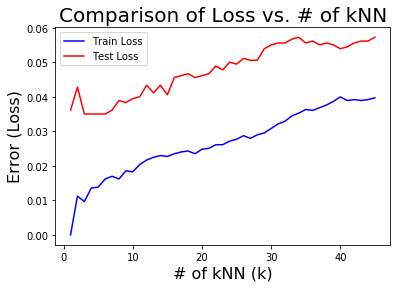

In [11]:
test_data = load_digits()
test_KNN = KNN(test_data[0],test_data[1])
kNN_mah_loss_tr = test_KNN.train_loss(45,test_KNN.mahalanobis)
kNN_mah_loss = test_KNN.test_loss(45,test_KNN.mahalanobis,test_data[2],test_data[3])
print('Min Train Loss Mah: {},(k={})'.format(min(kNN_mah_loss_tr),np.argmin(kNN_mah_loss_tr)+1))
print('Min Test Loss Mah: {},(k={})'.format(min(kNN_mah_loss),np.argmin(kNN_mah_loss)+1))
showErrorByK(kNN_mah_loss,kNN_mah_loss_tr,'Mahalanobis','Digits')

<p>For the Optidigits dataset with Mahalanobis distance, we observe the best value <i>k</i> to be <i>k</i> = 7. Likewise to the other models, <i>k</i> = 7 is a minimal test loss ( 0.035 ), an odd value of k, and is as at generalizing as any other <i>k</i> values in this model. Notice that even with Mahalanobis distance the model still overfits to training data in the Optidigits dataset, same as the other models with different distance metrics. It's also worth noting that the test loss of this model at any <i>k</i> value is significantly higher than the other models ( almost double! ). The most likely explanation for this discrepancy in loss between different distance metrics is that the Optidigits train data does not have a tight distribution ( i.e. Optidigits has large standard deviation for each feature ). Since Mahalanobis distance, in essence, describes a point's distance from a distribution of data and the distribution is not tight, Mahalanobis distance is not the best distance metric to use on the Optidigits dataset.</p>
<p></p>
<p>Mahalanobis distance using the <b>HTRU2 dataset:</b></p>

Min Train Loss Mah: 0.0,(k=1)
Min Test Loss Mah: 0.015083798882681564,(k=5)

Mahalanobis
HTRU2


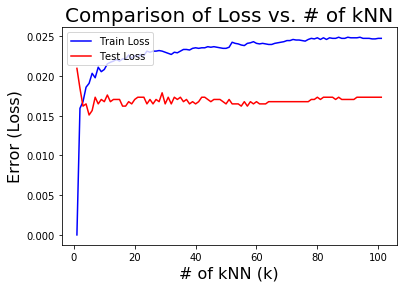

In [12]:
test_data = load_HTRU2()
test_KNN = KNN(test_data[0],test_data[1])
kNN_mah_loss_tr = test_KNN.train_loss(101,test_KNN.mahalanobis)
kNN_mah_loss = test_KNN.test_loss(101,test_KNN.mahalanobis,test_data[2],test_data[3])
print('Min Train Loss Mah: {},(k={})'.format(min(kNN_mah_loss_tr),np.argmin(kNN_mah_loss_tr)+1))
print('Min Test Loss Mah: {},(k={})'.format(min(kNN_mah_loss),np.argmin(kNN_mah_loss)+1))
showErrorByK(kNN_mah_loss,kNN_mah_loss_tr,'Mahalanobis','HTRU2')

<p>A good <i>k</i> for the HTRU2 dataset is <i>k</i>  = 57. At this point we have a good trade off between complexity ( lower <i>k</i> values ) and test loss. The test loss at <i>k</i> = 57 is still relatively low among all <i>k</i> values in this model. For the same reasons listed earlier, this HTRU2 dataset tends to have a lower test loss than train loss. Another key point to note is that the Mahalanobis distance metric performed much better than other distance metrics for the same dataset ( about 0.05 less test loss among all <i>k</i> values ). This is because the HTRU2 training data is likely tightly clustered around a distribution, thus points that are far from this distribution have a low rank in the nearest neighbors ranking and the classification of query points relies on neighbors closely distributed around it.</p><p></p>Among all the different models, the Mahalanobis distance for the HTRU2 dataset had the best performance. The model had the lowest loss of all models ( other than the one abnormal loss of 0 in the Euclidean Iris model ) , great generalizability, and low variance.</p>. It had the lowest loss at <i>k</i> = 5 of 0.0151. Even though the loss at the <i>k</i> I chose is slightly higher ( approximately 0.017 ), the model still outperforms the other models. 

### 2a)

In [13]:
# ran at alpha = 1.8e-4
test_data = load_HTRU2()
prefLbl = 1
test_logreg = LogisticRegression(test_data[0], test_data[1], prefLbl)
initTheta = np.zeros((test_data[0].shape[1]+1,1))
test_logreg.gradient_descent(initial_Theta=initTheta,epsilon=0.00005)
lr_score_tr = ((test_logreg.prob(test_data[0])>0.5) == (test_data[1]==prefLbl)).sum()/test_data[1].shape[0]
lr_score = ((test_logreg.prob(test_data[2])>0.5) == (test_data[3]==prefLbl)).sum()/test_data[3].shape[0]
print("Train LogReg score: {}".format(lr_score_tr))
print("Test LogReg score: {}".format(lr_score))

Converged, iteration 1240
Train LogReg score: 0.9703869255482609
Test LogReg score: 0.9773743016759776


<p>Comparing the logistic regression model to the kNN model on the HTRU2 dataset, we see that the logistic regression model performed worse than all three of the kNN models ( one for each distance function ). The difference in performance between the best kNN classifer ( Mahalanobis had 0.015 loss ) and the logistic regression model ( 0.02247 loss ) is clear, the logistic regression model performs worse on test data. The reasons for this are discussed more in 2c) .</p>

### 2b)

In [14]:
# ran at alpha = 1.2e-3
test_data = load_iris()
lrList = [LogisticRegression(test_data[0], test_data[1], pref) for pref in np.unique(test_data[1])]
initTheta = np.zeros((test_data[0].shape[1]+1,1))
for lr in lrList:
    lr.gradient_descent(initial_Theta=initTheta,epsilon=0.00005)
mlr_score_tr = multiclass_logistic_score(lrList,test_data[0],test_data[1])
mlr_score = multiclass_logistic_score(lrList,test_data[2],test_data[3])
print("Train MultiLogReg score: {}".format(mlr_score_tr))
print("Test MultiLogReg score: {}".format(mlr_score))

Converged, iteration 14722
Converged, iteration 16400
Converged, iteration 32459
Train MultiLogReg score: 0.975
Test MultiLogReg score: 0.9666666666666667


<p>At alpha = 1.2e-3, the test and train loss of logistic regression on the Iris dataset is 0.0333 . This value is identical to the best loss for <i>k</i> in all the kNN models.</p>

In [15]:
# ran at alpha = 1.65e-3
test_data = load_digits()
lrList = [LogisticRegression(test_data[0], test_data[1], pref) for pref in np.unique(test_data[1])]
initTheta = np.zeros((test_data[0].shape[1]+1,1))
for lr in lrList:
    lr.gradient_descent(initial_Theta=initTheta,epsilon=0.00005)
mlr_score_tr = multiclass_logistic_score(lrList,test_data[0],test_data[1])
mlr_score = multiclass_logistic_score(lrList,test_data[2],test_data[3])
print("Train MultiLogReg score: {}".format(mlr_score_tr))
print("Test MultiLogReg score: {}".format(mlr_score))

Converged, iteration 2627
Converged, iteration 3521
Converged, iteration 3319
Converged, iteration 3604
Converged, iteration 4108
Converged, iteration 4168
Converged, iteration 2883
Converged, iteration 3112
Converged, iteration 4148
Converged, iteration 4755
Train MultiLogReg score: 0.9659952916557677
Test MultiLogReg score: 0.9387868670005565


<p>Using a slightly modified alpha value of alpha = 1.65e-3 to drive loss down ( alpha = 1e-3 has larger test loss ), we have a logistic regression test loss of 0.059. This value is larger than the best kNN test loss value of 0.02 with Euclidean distance metric ( almost 3 times as large! ). In fact, all three kNN models ( one for each distance metric ) perform better than the logistic regression model. Clearly the kNN classifiers do a better job than the logistic regression model for the Optidigits dataset.

### 2c)

<p>In general, logistic regression models perform well when the datasets are "simpler" (i.e. fewer features and less classes ). This is because logistic regression's probabilistic perspective does a good job at classifying "edge" cases between two classes. As stated earlier, kNN models struggle when the majority class for a query class is a split vote between a group of kNN, which occurs most in small datasets. In larger datasets with a large number of features ( like Optidigits and HTRU2 ), logarithmic regression struggles because the overall loss is calculated by the sum of missed classifications per preffered class over the total number of classifications attempted. More specifically, logisitc regression struggles when there are many classes and two different classes both have high probabilities for a given query point since only the max probability is chosen as the query point class. Thus, in general, loss increases in logistic regression with number of features and number of classes; whereas kNN does a better job with larger datasets and more features because the overall variance is decreased and the number of "edge" cases decreases. Adding on to that, logistic models do just as well as kNN with high variance data ( and maybe even better if Iris had even fewer features ).</p><p>This explains why the logistic regression model performed much worse on the Optidigits dataset than the kNN models ( high number of features and classes ), slightly worse than kNN on the HTRU2 dataset ( moderate amount of features and binary class labels ), and just as well as kNN on Iris ( small number of features and small number of classes ). For this homework, none of the datasets fit logistic regressions preferred parameters perfectly ( small number of features and binary class labels ) which is why logistic regression doesn't outperform kNN in any of the datasets. It would be interesting to test the Iris dataset with more testing data to see if the high variance in the Iris kNN models would underperform in practice compared the logistic regression.</p><p>Finally, we note that of all the datasets, logistic regression performed best on the HTRU2 dataset because there of the large training data size. This does not imply that we should use logistic regression for a dataset similar to HTRU2, kNN still outperforms logistic regression by a landslide on HTRU2. It simply shows that in general, a models performance improves as more training data is introduced ( this holds for both kNN ad logistic regression ).</p>